### Exercise Sheet 2

#### 2.1 Solving a ODE with TorchPhysics
Use TorchPhysics to solve the ODE for falling with a parachute:
\begin{align*}
    \partial_t^2 u(t) &= D(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}
If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell.

In [ ]:
!pip install torchphysics

In [1]:
import torch
import torchphysics as tp
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0
D_min, D_max = 0.01, 1.0
g, H = 9.81, 50.0

# number of time points 
N_t = 5000
N_initial = 100

train_iterations = 5000
learning_rate = 1.e-3

Using the [lecture example](https://github.com/TomF98/torchphysics/tree/main/examples) gives a good guide for working with TorchPhysics.

In [2]:
### TODO: Implement the spaces
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
D = tp.spaces.R1('D')
### TODO: Define the time interval 
int_t = tp.domains.Interval(T, t_min, t_max)
int_D = tp.domains.Interval(D, D_min, D_max)
### TODO: Create sampler for points inside and at the left boundary
ode_sampler = tp.samplers.RandomUniformSampler(int_t*int_D, n_points=N_t)
initial_sampler = tp.samplers.RandomUniformSampler(int_t.boundary_left*int_D, n_points=N_initial)

In [3]:
### TODO: Create neural network
model = tp.models.FCN(T*D, U, hidden=(20, 20))

In [4]:
### TODO: Define condition for the ODE:
def ode_residual(u, t, D):
    u_t = tp.utils.grad(u, t)
    u_tt = tp.utils.grad(u_t, t)
    return u_tt - D*u_t**2 + g

ode_condition = tp.conditions.PINNCondition(model, ode_sampler, ode_residual)

In [5]:
### TODO: Define condition for the initial position:
def position_residual(u):
    return u - H

initial_position_condition = tp.conditions.PINNCondition(model, initial_sampler, position_residual)

In [6]:
### TODO: Define condition for the initial velocity:
def velocity_residual(u, t):
    return tp.utils.grad(u, t)

initial_velocity_condition = tp.conditions.PINNCondition(model, initial_sampler, velocity_residual)

In [7]:
### Syntax for the training is already implemented:

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate) 
solver = tp.solver.Solver([ode_condition, initial_position_condition, initial_velocity_condition],
                          optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 501   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
501       Trainable params
0         Non-trainable params
501       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'absolute error')

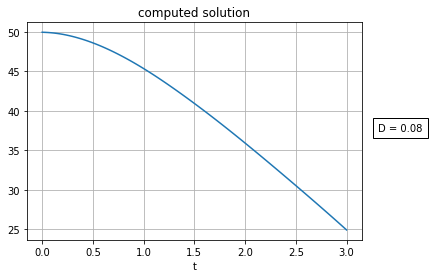

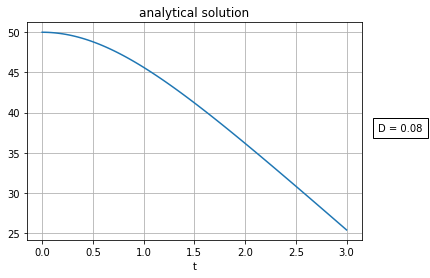

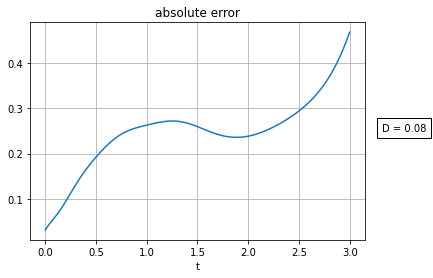

In [ ]:
### Here, plot the solution and the error:
import matplotlib.pyplot as plt
D_test = 0.08

def analytic_solution(t, D):
    return 1/D * (-torch.log((1+torch.exp(-2*torch.sqrt(D*g)*t))/2) - torch.sqrt(D*g)*t) + H

plot_sampler = tp.samplers.PlotSampler(int_t, 100, data_for_other_variables={'D': D_test})
fig = tp.utils.plot(model, lambda u: u, plot_sampler)
plt.title("computed solution")

plot_sampler = tp.samplers.PlotSampler(int_t, 100, data_for_other_variables={'D': D_test})
fig = tp.utils.plot(model, lambda t,D: analytic_solution(t, D), plot_sampler)
plt.title("analytical solution")

fig = tp.utils.plot(model, lambda u,t,D: torch.abs(u - analytic_solution(t, D)), plot_sampler)
plt.title("absolute error")